In [1]:
import tensorflow as tf
import numpy as np
from network_parts import *
import matplotlib.pyplot as plt
from utils import *
import PIL

%matplotlib inline

In [2]:
shape = 100, 100
num_channels = 1
vec_size = 64
num_classes = 10

### Architecture

In [3]:
blank = tf.placeholder(tf.float32)

# Optimization variables

z_vector = tf.Variable(np.zeros(shape=[1, vec_size]), dtype=tf.float32)
target_vector = tf.Variable(np.zeros(shape=[1, num_classes]), dtype=tf.float32)

# VAE Input

input_images = tf.placeholder(tf.float32, shape=[None, shape[0], shape[1], num_channels])

In [4]:
with tf.variable_scope('encoder'):
    mean, std = encoder(input_images, vec_size)

encoded = mean + std * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)

In [5]:
with tf.variable_scope('decoder'):
    decoded = decoder(z_vector, vec_size, shape)

In [6]:
with tf.variable_scope('classifier'):
    classified = classifier(z_vector, num_classes)

In [7]:
probs = tf.nn.softmax(classified)

In [8]:
loss = tf.reduce_mean(-tf.reduce_sum(target_vector * tf.log(probs), reduction_indices=[1]))

In [9]:
optim = tf.train.AdamOptimizer().minimize(loss, var_list=[z_vector])

### Utils

In [10]:
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

In [11]:
vae_weights = list(filter(lambda x: 'decoder' in x.name or 'encoder' in x.name, tf.global_variables()))

In [12]:
classifier_weights = list(filter(lambda x: 'classifier' in x.name, tf.global_variables()))

In [13]:
tf.train.Saver(classifier_weights).restore(sess, 'weights/classifier')
tf.train.Saver(vae_weights).restore(sess, 'new_weights/VAE_notMNIST_56')

### Optimization

In [14]:
def new_class_structure(target_classes, classes):
    new = np.zeros(len(classes))
    for cl in target_classes:
        new[classes.index(cl)] = 10
    return new

In [15]:
def new_class_structure(current_class, target_classes, classes):
    new = current_class.copy()
    for cl in target_classes:
        new[classes.index(cl)] = 10
    return new

In [16]:
class_names = np.load('class_names').tolist()

In [17]:
X, Y = [], []
data_path = 'data/'
class_indexes = {}

for class_ind, dir in enumerate(class_names):
    if os.path.isdir(os.path.join(data_path, dir)):
        files = load_dir(os.path.join(data_path, dir), shape=shape)
        X.extend(files)
        Y.extend([class_ind for _ in range(len(files))])
        class_indexes[dir] = len(X)-len(files)

X = np.array(X)
Y = np.array(Y)

X = X.reshape([-1, shape[0], shape[1], 1])

In [19]:
class_names

['F', 'I', 'G', 'A', 'B', 'E', 'D', 'C', 'H', 'J']

In [281]:
ind = class_indexes['A']+64

In [307]:
vec = sess.run(encoded, feed_dict={input_images: [X[ind]]})

In [308]:
asignment_z = z_vector.assign(vec)
sess.run(asignment_z)

array([[  3.98736839e+01,   1.00901909e+02,   2.01028015e+02,
          9.82312858e-02,  -6.88410950e+01,   2.79725971e+01,
          1.61163006e+01,   9.03951721e+01,   1.73343582e+02,
          1.07758514e+02,   1.23503246e+01,  -7.39635773e+01,
          5.34216919e+01,   6.82088318e+01,   6.61275330e+01,
         -9.41066284e+01,   2.11755478e+02,  -1.67714462e+02,
          8.47731531e-01,  -5.25124321e+01,   5.78339767e+01,
          2.38577698e+02,   1.17026543e+02,   2.13672470e+02,
         -5.72195816e+01,  -1.56575455e+02,   5.70481949e+01,
          5.19777489e+01,  -9.90358429e+01,  -6.57707787e+00,
          6.24946098e+01,   1.95921173e+02,  -1.60990479e+02,
          2.76512623e+01,   4.66258888e+01,   2.05279579e+01,
         -2.10999413e+01,  -2.38534069e+01,  -2.56640076e+02,
          2.26335938e+02,   1.61466236e+01,  -9.46100616e+00,
          1.32499573e+02,  -1.56083755e+02,  -1.46115448e+02,
         -9.59675217e+00,   2.14741528e-02,  -1.15520119e+02,
        

In [309]:
new_class = np.zeros(len(class_names))
new_class[class_names.index('B')] = 10
#new_class[class_names.index('F')] = 5

In [310]:
asignment_y = target_vector.assign(np.array([new_class]))

sess.run(asignment_y)

array([[  0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

In [311]:
def print_classes(class_distribution, class_names):
    for name, value in zip(class_names, class_distribution):
        print(name, value, end=' ')
    print('\n')

In [312]:
for _ in range(300000):
    #cl = sess.run([probs], feed_dict={blank: 1})[0][0]
    
    if _ % 1000 == 0:
        cl = sess.run([probs], feed_dict={blank: 1})[0][0]
        print_classes(cl, class_names)
        
    #new_class = new_class_structure(cl, ['E'], class_names)

    #sess.run(target_vector.assign(np.array([new_class])))

    _, l = sess.run([optim, loss], feed_dict={blank: 1})

F 0.0410165 I 0.089739 G 0.314044 A 0.0353898 B 0.146172 E 0.0622129 D 0.0433874 C 0.138088 H 0.099199 J 0.0307513 

F 0.0248614 I 0.119615 G 0.228068 A 0.0404963 B 0.269715 E 0.0580348 D 0.0590767 C 0.0412108 H 0.143869 J 0.0150532 

F 0.0223688 I 0.121974 G 0.182687 A 0.0313718 B 0.345182 E 0.0587248 D 0.0547565 C 0.030188 H 0.144215 J 0.008532 

F 0.0206506 I 0.119066 G 0.146738 A 0.0235089 B 0.416321 E 0.0583784 D 0.0489336 C 0.0237403 H 0.137665 J 0.00499775 

F 0.0191538 I 0.112681 G 0.116826 A 0.0172171 B 0.485194 E 0.0567775 D 0.0428631 C 0.0190312 H 0.127302 J 0.00295399 

F 0.0177376 I 0.103922 G 0.091963 A 0.0123838 B 0.551098 E 0.0540056 D 0.0370326 C 0.0153076 H 0.114798 J 0.00175115 

F 0.0162895 I 0.0938731 G 0.0715116 A 0.00879267 B 0.6128 E 0.0503036 D 0.0316448 C 0.0122187 H 0.101529 J 0.00103729 

F 0.0145402 I 0.0836299 G 0.0547905 A 0.00627673 B 0.66912 E 0.0455796 D 0.0270417 C 0.00936276 H 0.0890431 J 0.000615839 

F 0.0117062 I 0.0747029 G 0.0407966 A 0.00478433

KeyboardInterrupt: 

In [313]:
a = sess.run(decoded, feed_dict={blank: 1}).reshape(shape)

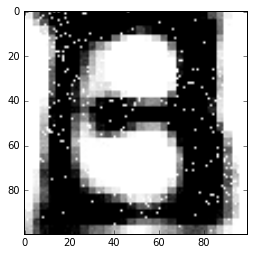

In [314]:
plt.imshow(PIL.Image.fromarray(a.reshape(shape).astype(np.uint8)), cmap='Greys')

In [302]:
ind = class_indexes['A']+97

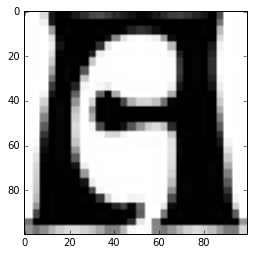

In [304]:
plt.imshow(PIL.Image.fromarray(X[ind].reshape(shape).astype(np.uint8)), cmap='Greys')

In [243]:
good_idx = [12]